In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hosseinakbari2000","key":"a05d1880a62c31fdf8ee773602346af8"}'}

In [3]:
import os
import shutil

os.makedirs('/root/.kaggle', exist_ok=True)
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

# Set permissions
os.chmod('/root/.kaggle/kaggle.json', 600)

In [4]:
!kaggle datasets download -d kausthubkannan/5-flower-types-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/kausthubkannan/5-flower-types-classification-dataset
License(s): other
 99% 240M/242M [00:14<00:00, 22.2MB/s]
100% 242M/242M [00:14<00:00, 17.8MB/s]


In [5]:
import zipfile

# Create a directory to extract the contents
extract_dir = '/content/'  # Define a new directory for extraction

with zipfile.ZipFile('/content/5-flower-types-classification-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_dir)  # Use the new directory for extraction

In [6]:
#Import Os and Basis Libraries
import cv2
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#Matplot Images
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
# Tensflor and Keras Layer and Model and Optimize and Loss
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy
#Kernel Intilizer
from tensorflow.keras.initializers import he_normal
# import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
#PreTrained Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception
#Image Generator DataAugmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
# Warnings Remove
import warnings
warnings.filterwarnings("ignore")
#Splitting Data
# import splitfolders
from keras.regularizers import l2

In [8]:
import os
import pandas as pd

# Define the main directory where images are stored
directory = "/content/flower_images"

filepath = []  # List to store file paths
label = []  # List to store labels

# List of subdirectories (folders) in the main directory
folds = os.listdir(directory)

# Dictionary to keep track of the number of images per class
class_image_counts = {}

for fold in folds:
    f_path = os.path.join(directory, fold)

    # Check if the current path is a directory
    if os.path.isdir(f_path):
        # List all files in the directory
        imgs = os.listdir(f_path)

        # Count the number of images for each class
        class_image_counts[fold] = len(imgs)

        for img in imgs:
            img_path = os.path.join(f_path, img)

            # Check if the current path is a file
            if os.path.isfile(img_path):
                filepath.append(img_path)
                label.append(fold)
            else:
                print(f"Warning: {img_path} is not a valid file.")
    else:
        print(f"Warning: {f_path} is not a valid directory.")

# Create a DataFrame from the file paths and labels
file_path_series = pd.Series(filepath, name='filepath')
label_path_series = pd.Series(label, name='label')
df_train = pd.concat([file_path_series, label_path_series], axis=1)

# Display details
print(f"Total number of images: {len(filepath)}")
print(f"Number of images per class:")
for class_name, count in class_image_counts.items():
    print(f" - {class_name}: {count} images")

# Display a sample of the DataFrame
print("\nSample of the DataFrame:")
print(df_train.head())


Total number of images: 5000
Number of images per class:
 - Lilly: 1000 images
 - Lotus: 1000 images
 - Orchid: 1000 images
 - Sunflower: 1000 images
 - Tulip: 1000 images

Sample of the DataFrame:
                                      filepath  label
0  /content/flower_images/Lilly/3d68be84ab.jpg  Lilly
1  /content/flower_images/Lilly/d44e2890f2.jpg  Lilly
2  /content/flower_images/Lilly/e7c73d9865.jpg  Lilly
3  /content/flower_images/Lilly/b0680edccf.jpg  Lilly
4  /content/flower_images/Lilly/9318c50eb0.jpg  Lilly


Data Spliting


In [9]:
# Spliting in Train and Dummy
train_df , dummy_df = train_test_split(df_train ,train_size = 0.8 , shuffle = True ,random_state = 42 )
# Spliting in Validation and Test From Dummy
valid_df , test_df = train_test_split(dummy_df ,test_size= 0.5 , shuffle = True ,random_state = 42)

In [10]:
print(f"The shape of The Train data is: {train_df.shape}")
print(f"The shape of The Validation data is: {valid_df.shape}")
print(f"The shape of The Test data is: {test_df.shape}")

The shape of The Train data is: (4000, 2)
The shape of The Validation data is: (500, 2)
The shape of The Test data is: (500, 2)


Making Train Test And Validation Datasets

In [11]:
# Create ImageDataGenerator instances for  Train , validation and test sets (only rescale pixel values)
train_datagen = ImageDataGenerator(rescale=1./255,)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size
batch_size = 32

# Flow images from dataframes and apply augmentation (if any)
print("Training Data")
train_ds = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

print("Validation Data")
validation_ds = validation_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

print("Test Data")
test_ds = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Training Data
Found 4000 validated image filenames belonging to 5 classes.
Validation Data
Found 500 validated image filenames belonging to 5 classes.
Test Data
Found 500 validated image filenames belonging to 5 classes.


In [12]:
# Load the DenseNet121 base model without the top (classification) layer
from tensorflow.keras.applications import DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, pooling='max', input_shape=(224, 224, 3))

# Freeze the layers in the base model
base_model.trainable = False

# Build Model
model = Sequential()

# Base Model
model.add(base_model)

# Batch Normalization
model.add(BatchNormalization())

# Dense Layer 1
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01),
               ))

# Batch Normalization
model.add(BatchNormalization())

# Dropout Layer
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(5, activation='softmax'))

# Compile
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])



29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

#Fitting Model
history = model.fit(train_ds,
                        epochs= 100,
#                         steps_per_epoch = len(train_ds),
                        validation_data = validation_ds,
#                         validation_steps = len(validation_ds),
                        callbacks = early_stopping)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 67s 291ms/step - accuracy: 0.5994 - loss: 4.8023 - val_accuracy: 0.8340 - val_loss: 3.3224
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 145ms/step - accuracy: 0.8384 - loss: 3.1344 - val_accuracy: 0.8820 - val_loss: 2.7430
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 194ms/step - accuracy: 0.8829 - loss: 2.6254 - val_accuracy: 0.8920 - val_loss: 2.3936
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - accuracy: 0.9021 - loss: 2.2753 - val_accuracy: 0.9060 - val_loss: 2.1318
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.9239 - loss: 2.0136 - val_accuracy: 0.9120 - val_loss: 1.9129
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step - accuracy: 0.9354 - loss: 1.7839 - val_accuracy: 0.9180 - val_loss: 1.7251
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.9522 - loss: 1.5968 - val_accuracy: 0.9360 - val_loss: 1.5540
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - accuracy: 0.9567 -

In [14]:
#model.save('flower_classification_model.h5')

In [15]:
validation_loss, validation_accuracy = model.evaluate(validation_ds)

# Print the validation loss and accuracy
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9433 - loss: 0.2447
Validation Loss: 0.23515765368938446
Validation Accuracy: 0.9520000219345093


In [16]:
# Evaluate the model on the validation dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the validation loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9512 - loss: 0.3205
Test Loss: 0.3167663514614105
Test Accuracy: 0.9459999799728394


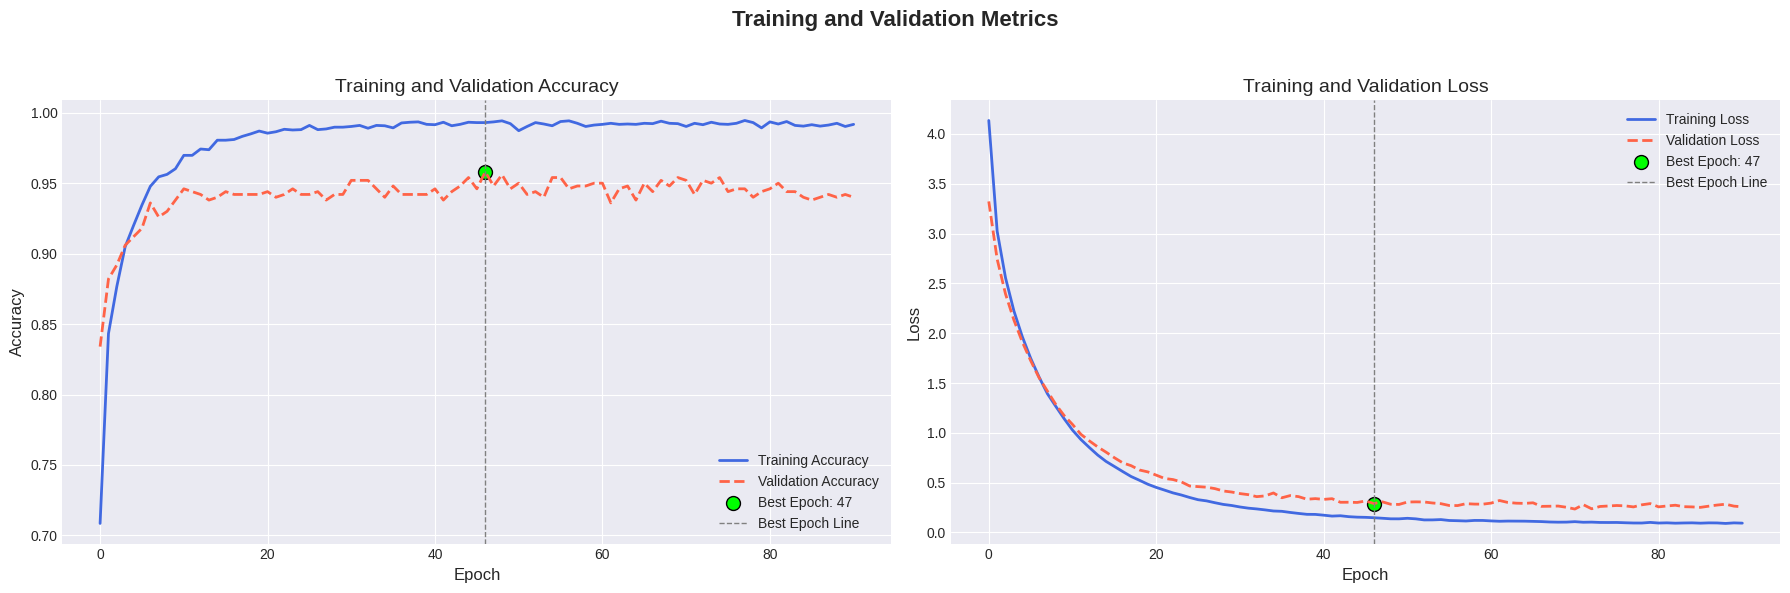

In [17]:

import seaborn as sns

# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Set the background style
plt.style.use('seaborn-darkgrid')

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(18, 6))  # Increased width for better visibility

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='royalblue', linestyle='-', linewidth=2)
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='tomato', linestyle='--', linewidth=2)
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='lime', s=100, edgecolor='black', label=f'Best Epoch: {best_epoch}')
axs[0].axvline(x=best_epoch - 1, color='grey', linestyle='--', linewidth=1, label='Best Epoch Line')
axs[0].set_xlabel('Epoch', fontsize=12)
axs[0].set_ylabel('Accuracy', fontsize=12)
axs[0].set_title('Training and Validation Accuracy', fontsize=14)
axs[0].legend(loc='lower right')
axs[0].grid(True)

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='royalblue', linestyle='-', linewidth=2)
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='tomato', linestyle='--', linewidth=2)
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='lime', s=100, edgecolor='black', label=f'Best Epoch: {best_epoch}')
axs[1].axvline(x=best_epoch - 1, color='grey', linestyle='--', linewidth=1, label='Best Epoch Line')
axs[1].set_xlabel('Epoch', fontsize=12)
axs[1].set_ylabel('Loss', fontsize=12)
axs[1].set_title('Training and Validation Loss', fontsize=14)
axs[1].legend(loc='upper right')
axs[1].grid(True)

# Adjust layout and add a main title
plt.suptitle('Training and Validation Metrics', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the main title

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Classification Report:
              precision    recall  f1-score   support

       Lilly       0.91      0.90      0.91       115
       Lotus       0.94      0.93      0.93        95
      Orchid       0.94      0.98      0.96        91
   Sunflower       0.99      0.99      0.99       106
       Tulip       0.96      0.94      0.95        93

    accuracy                           0.95

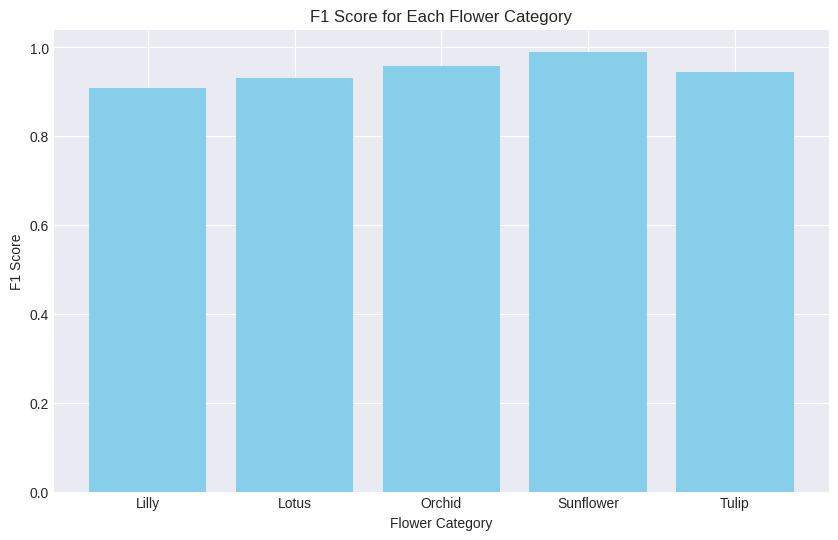

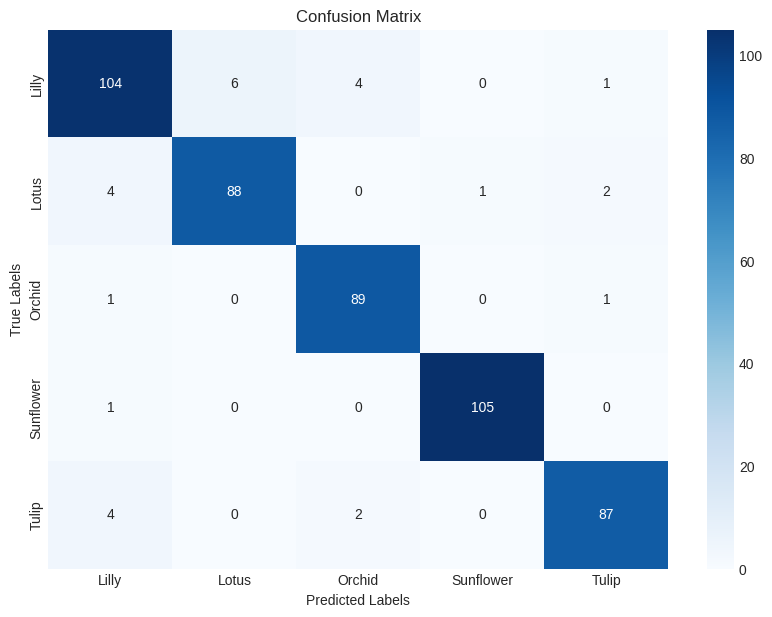

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns

# Obtain predictions and true labels for the test dataset
y_true = []
y_pred = []

# Iterate through the test dataset to get images and labels
for _ in range(len(test_ds)):
    images, labels = next(test_ds)
    predictions = model.predict(images)

    # Add true labels to the y_true list
    y_true.extend(np.argmax(labels, axis=1))

    # Add predicted labels to the y_pred list
    y_pred.extend(np.argmax(predictions, axis=1))

# Calculate F1 score for each class
f1 = f1_score(y_true, y_pred, average=None)

# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Plot the F1 score for each class
plt.figure(figsize=(10, 6))
plt.bar(class_labels, f1, color='skyblue')
plt.xlabel('Flower Category')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Flower Category')
plt.show()

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


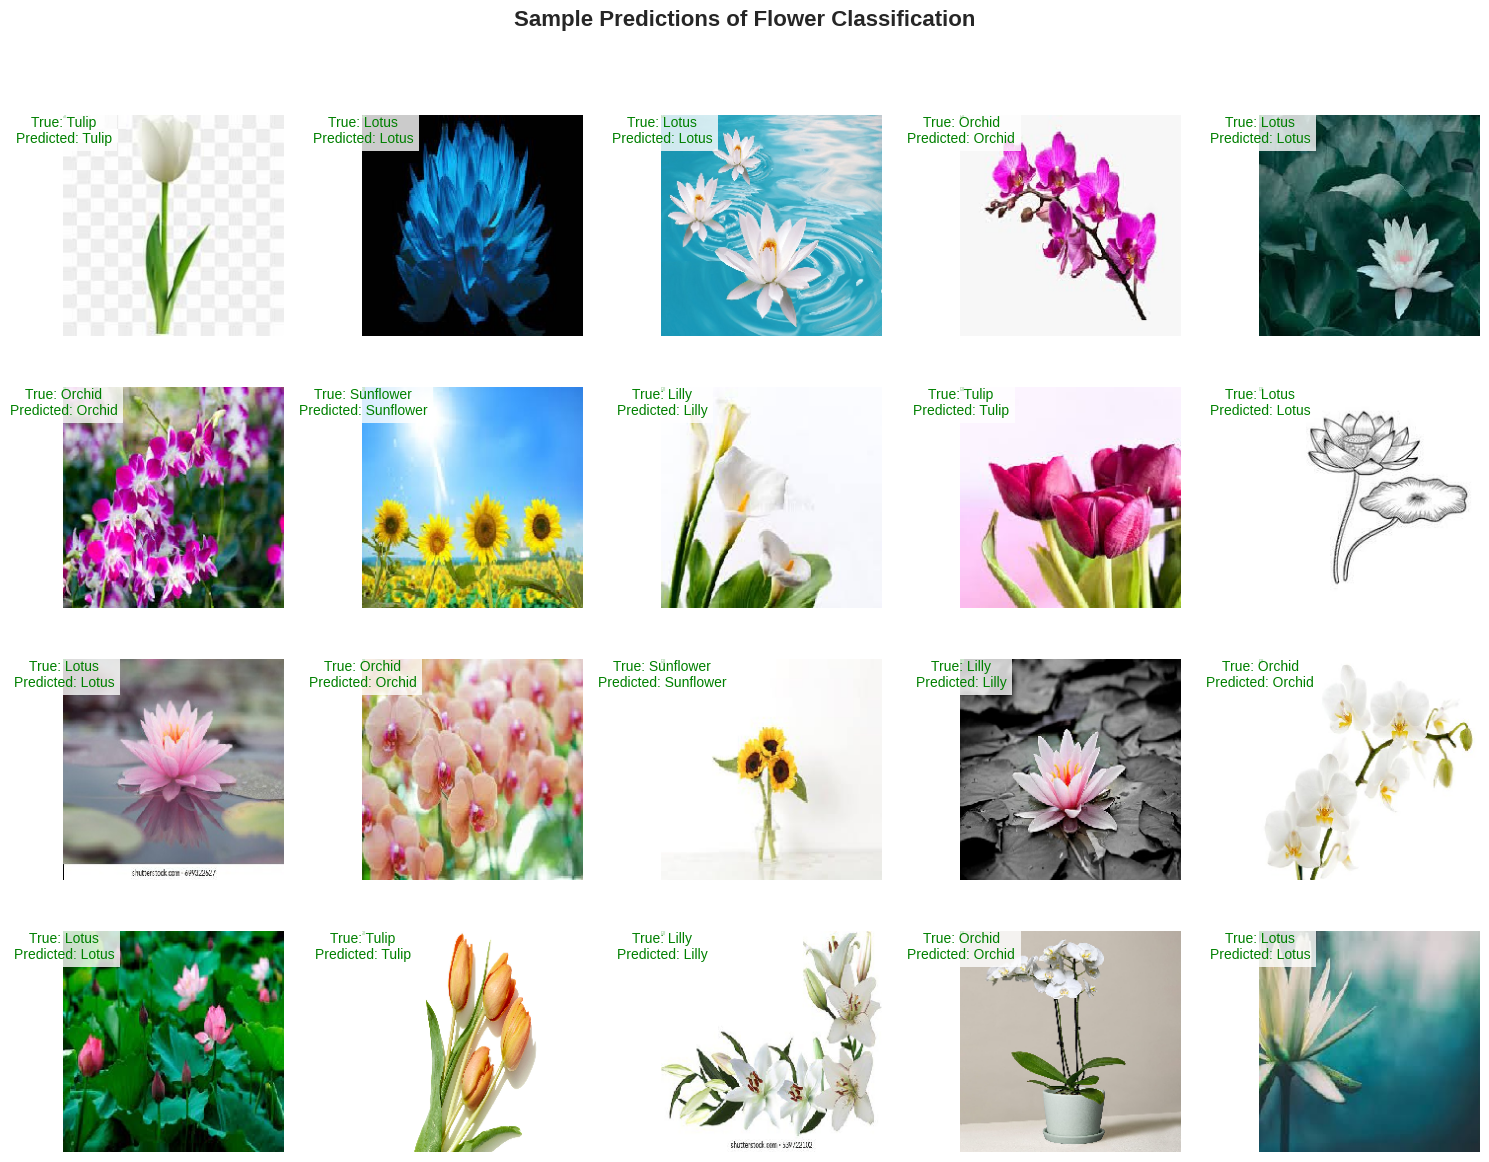

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# List of class labels
class_labels = list(test_ds.class_indices.keys())

# Number of images to display and layout configuration
num_images = 20
num_images_per_row = 5
num_rows = (num_images + num_images_per_row - 1) // num_images_per_row  # Compute number of rows needed

# Create a new figure with a tight layout
plt.figure(figsize=(15, 12))  # Adjusted height for better visibility

# Loop through each image and its prediction
for i in range(num_images):
    # Get a batch of images and labels
    images, labels = next(test_ds)
    predictions = model.predict(images)

    # Loop through each image in the batch
    for j in range(len(images)):
        if i * len(images) + j < num_images:  # Ensure we don't exceed the desired number of images
            predicted_class = class_labels[np.argmax(predictions[j])]
            true_class = class_labels[np.argmax(labels[j])]

            # Set the color based on whether the prediction is correct
            border_color = 'green' if predicted_class == true_class else 'red'
            text_color = 'green' if predicted_class == true_class else 'red'

            plt.subplot(num_rows, num_images_per_row, i * len(images) + j + 1)
            plt.imshow(images[j])
            plt.axis('off')  # Hide axis to make border around image more prominent

            # Draw a border around the image
            plt.gca().add_patch(plt.Rectangle((0, 0), 1, 1, fill=None, edgecolor=border_color, linewidth=3))

            # Add text below the image
            plt.gca().text(0.5, -0.1, f'True: {true_class}\nPredicted: {predicted_class}',
                           ha='center', va='top', fontsize=10, color=text_color, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Add a main title and adjust layout
plt.suptitle('Sample Predictions of Flower Classification', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the main title

plt.show()
